# Model - 2

Second attempt at training a model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import boxcox
from sklearn.model_selection import (
    train_test_split,
    cross_validate,
    GridSearchCV,
    RandomizedSearchCV,
)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
TUNING = 0

<IPython.core.display.Javascript object>

In [3]:
train_df = pd.read_csv(
    "data/train.csv", parse_dates=["Scheduled Date", "Delivery Date"]
)
test_df = pd.read_csv("data/test.csv", parse_dates=["Scheduled Date", "Delivery Date"])

<IPython.core.display.Javascript object>

## Exploratory Data Analysis

### Univariate Analysis

In [4]:
cat_features = [
    "Artist Name",
    "Weight",
    "Material",
    "International",
    "Express Shipment",
    "Installation Included",
    "Transport",
    "Fragile",
    "Customer Information",
    "Remote Location",
    "Scheduled Date",
    "Delivery Date",
    "Customer Location",
]
num_features = [
    "Artist Reputation",
    "Height",
    "Width",
    "Weight",
    "Price Of Sculpture",
    "Base Shipping Price",
]

<IPython.core.display.Javascript object>

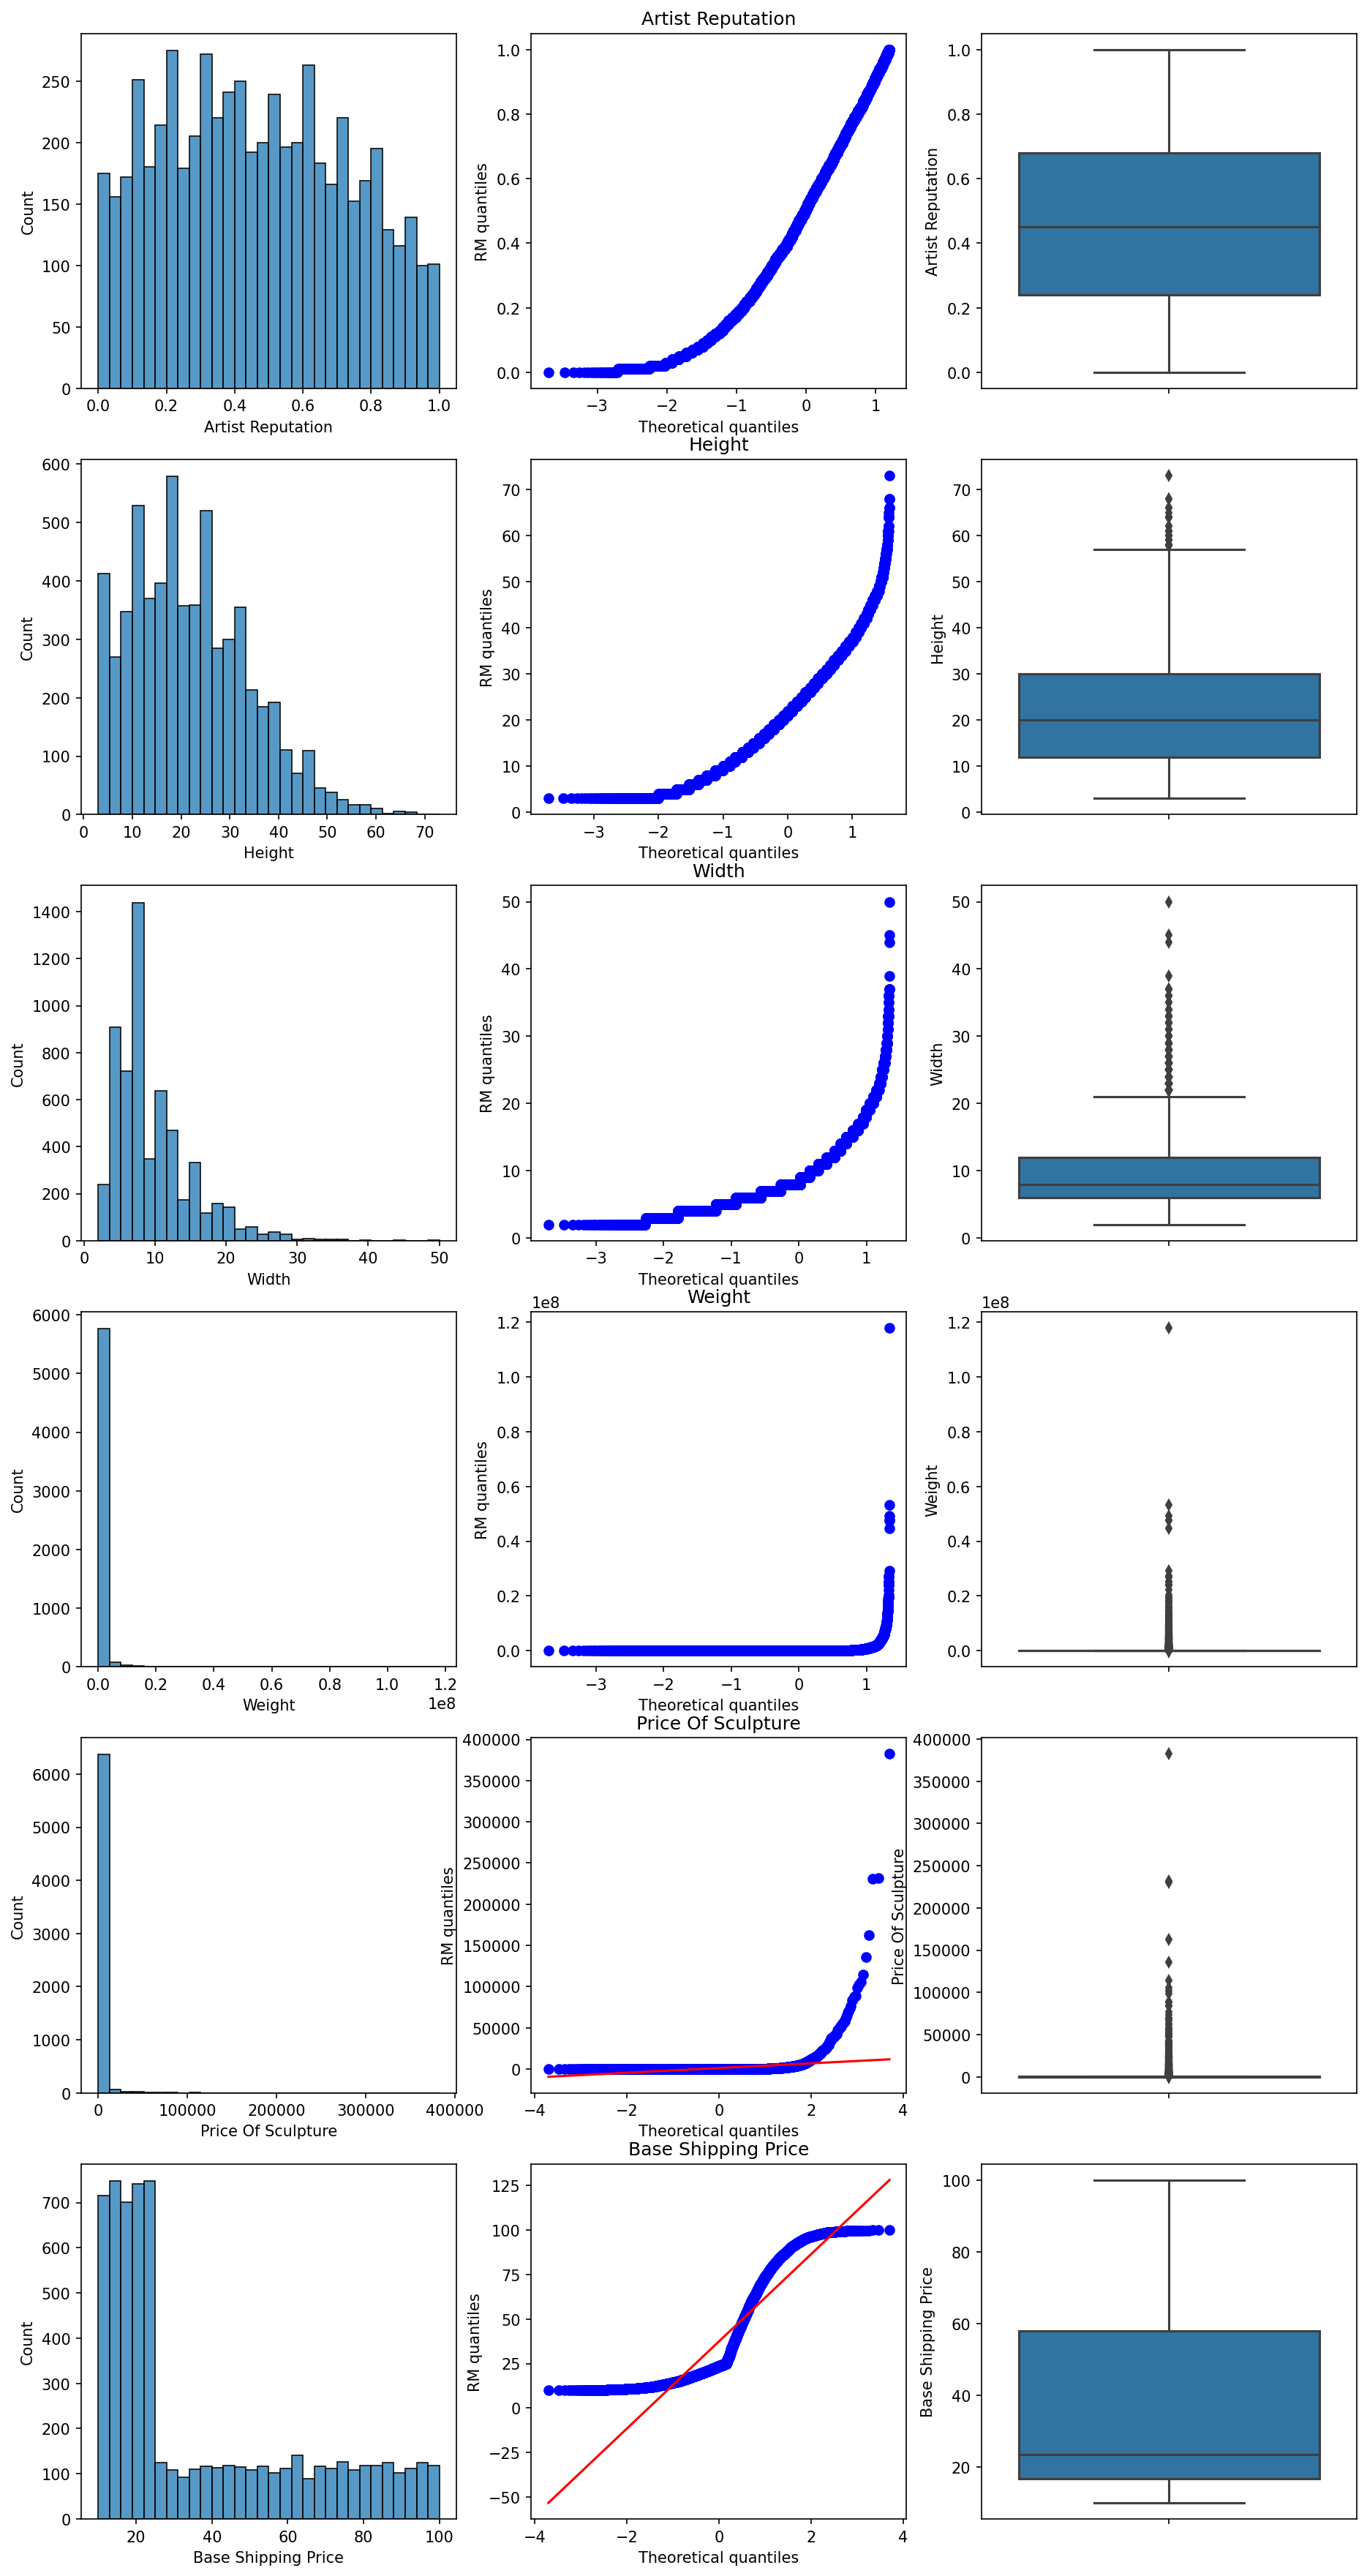

<IPython.core.display.Javascript object>

In [5]:
# define figure size
fig, ax = plt.subplots(
    nrows=len(num_features), ncols=3, figsize=(5 * 3, 5 * len(num_features)), dpi=150
)

for i, num_feature in enumerate(num_features):
    # histogram
    sns.histplot(train_df[num_feature], bins=30, ax=ax[i][0])

    # Q-Q plot
    stats.probplot(train_df[num_feature], dist="norm", plot=ax[i][1])
    ax[i][1].set_ylabel("RM quantiles")
    ax[i][1].set_title(num_feature)

    # boxplot
    sns.boxplot(y=train_df[num_feature], ax=ax[i][2])

plt.show()

## Cleaning Data

### Filling missing values

In [6]:
# filling Artist Reputation with the mean to make it normal distribution
train_df["Artist Reputation_NA"] = np.where(
    train_df["Artist Reputation"].isnull(), 1, 0
)
train_df["Artist Reputation"].fillna(train_df["Artist Reputation"].mean(), inplace=True)

# filling Transport with the mode
train_df["Transport_NA"] = np.where(train_df["Transport"].isnull(), 1, 0)
train_df["Transport"].fillna(train_df["Transport"].mode().item(), inplace=True)

# filling Remote Location with the mode
train_df["Remote_Location_NA"] = np.where(train_df["Remote Location"].isnull(), 1, 0)
train_df["Remote Location"].fillna(
    train_df["Remote Location"].mode().item(), inplace=True
)

# filling Height with the mean
train_df["Height_NA"] = np.where(train_df["Height"].isnull(), 1, 0)
train_df["Height"].fillna(train_df["Height"].mean(), inplace=True)

# filling Width with the mean
train_df["Width_NA"] = np.where(train_df["Width"].isnull(), 1, 0)
train_df["Width"].fillna(train_df["Width"].mean(), inplace=True)

# filling Weight with the median, due to skew
train_df["Weight_NA"] = np.where(train_df["Weight"].isnull(), 1, 0)
train_df["Weight"].fillna(train_df["Weight"].median(), inplace=True)

# filling Material with NA values
train_df["Material_NA"] = np.where(train_df["Material"].isnull(), 1, 0)
train_df["Material"].fillna(train_df["Material"].mode().item(), inplace=True)

<IPython.core.display.Javascript object>

### Normalizing variables

In [7]:
train_df["Width"] = boxcox(train_df["Width"], 0)
train_df["Weight"] = boxcox(train_df["Weight"], 0)
train_df["Price Of Sculpture"] = boxcox(train_df["Price Of Sculpture"], 0)
train_df["Cost"] = abs(train_df["Cost"])

<IPython.core.display.Javascript object>

Plotting the univariate plots again.

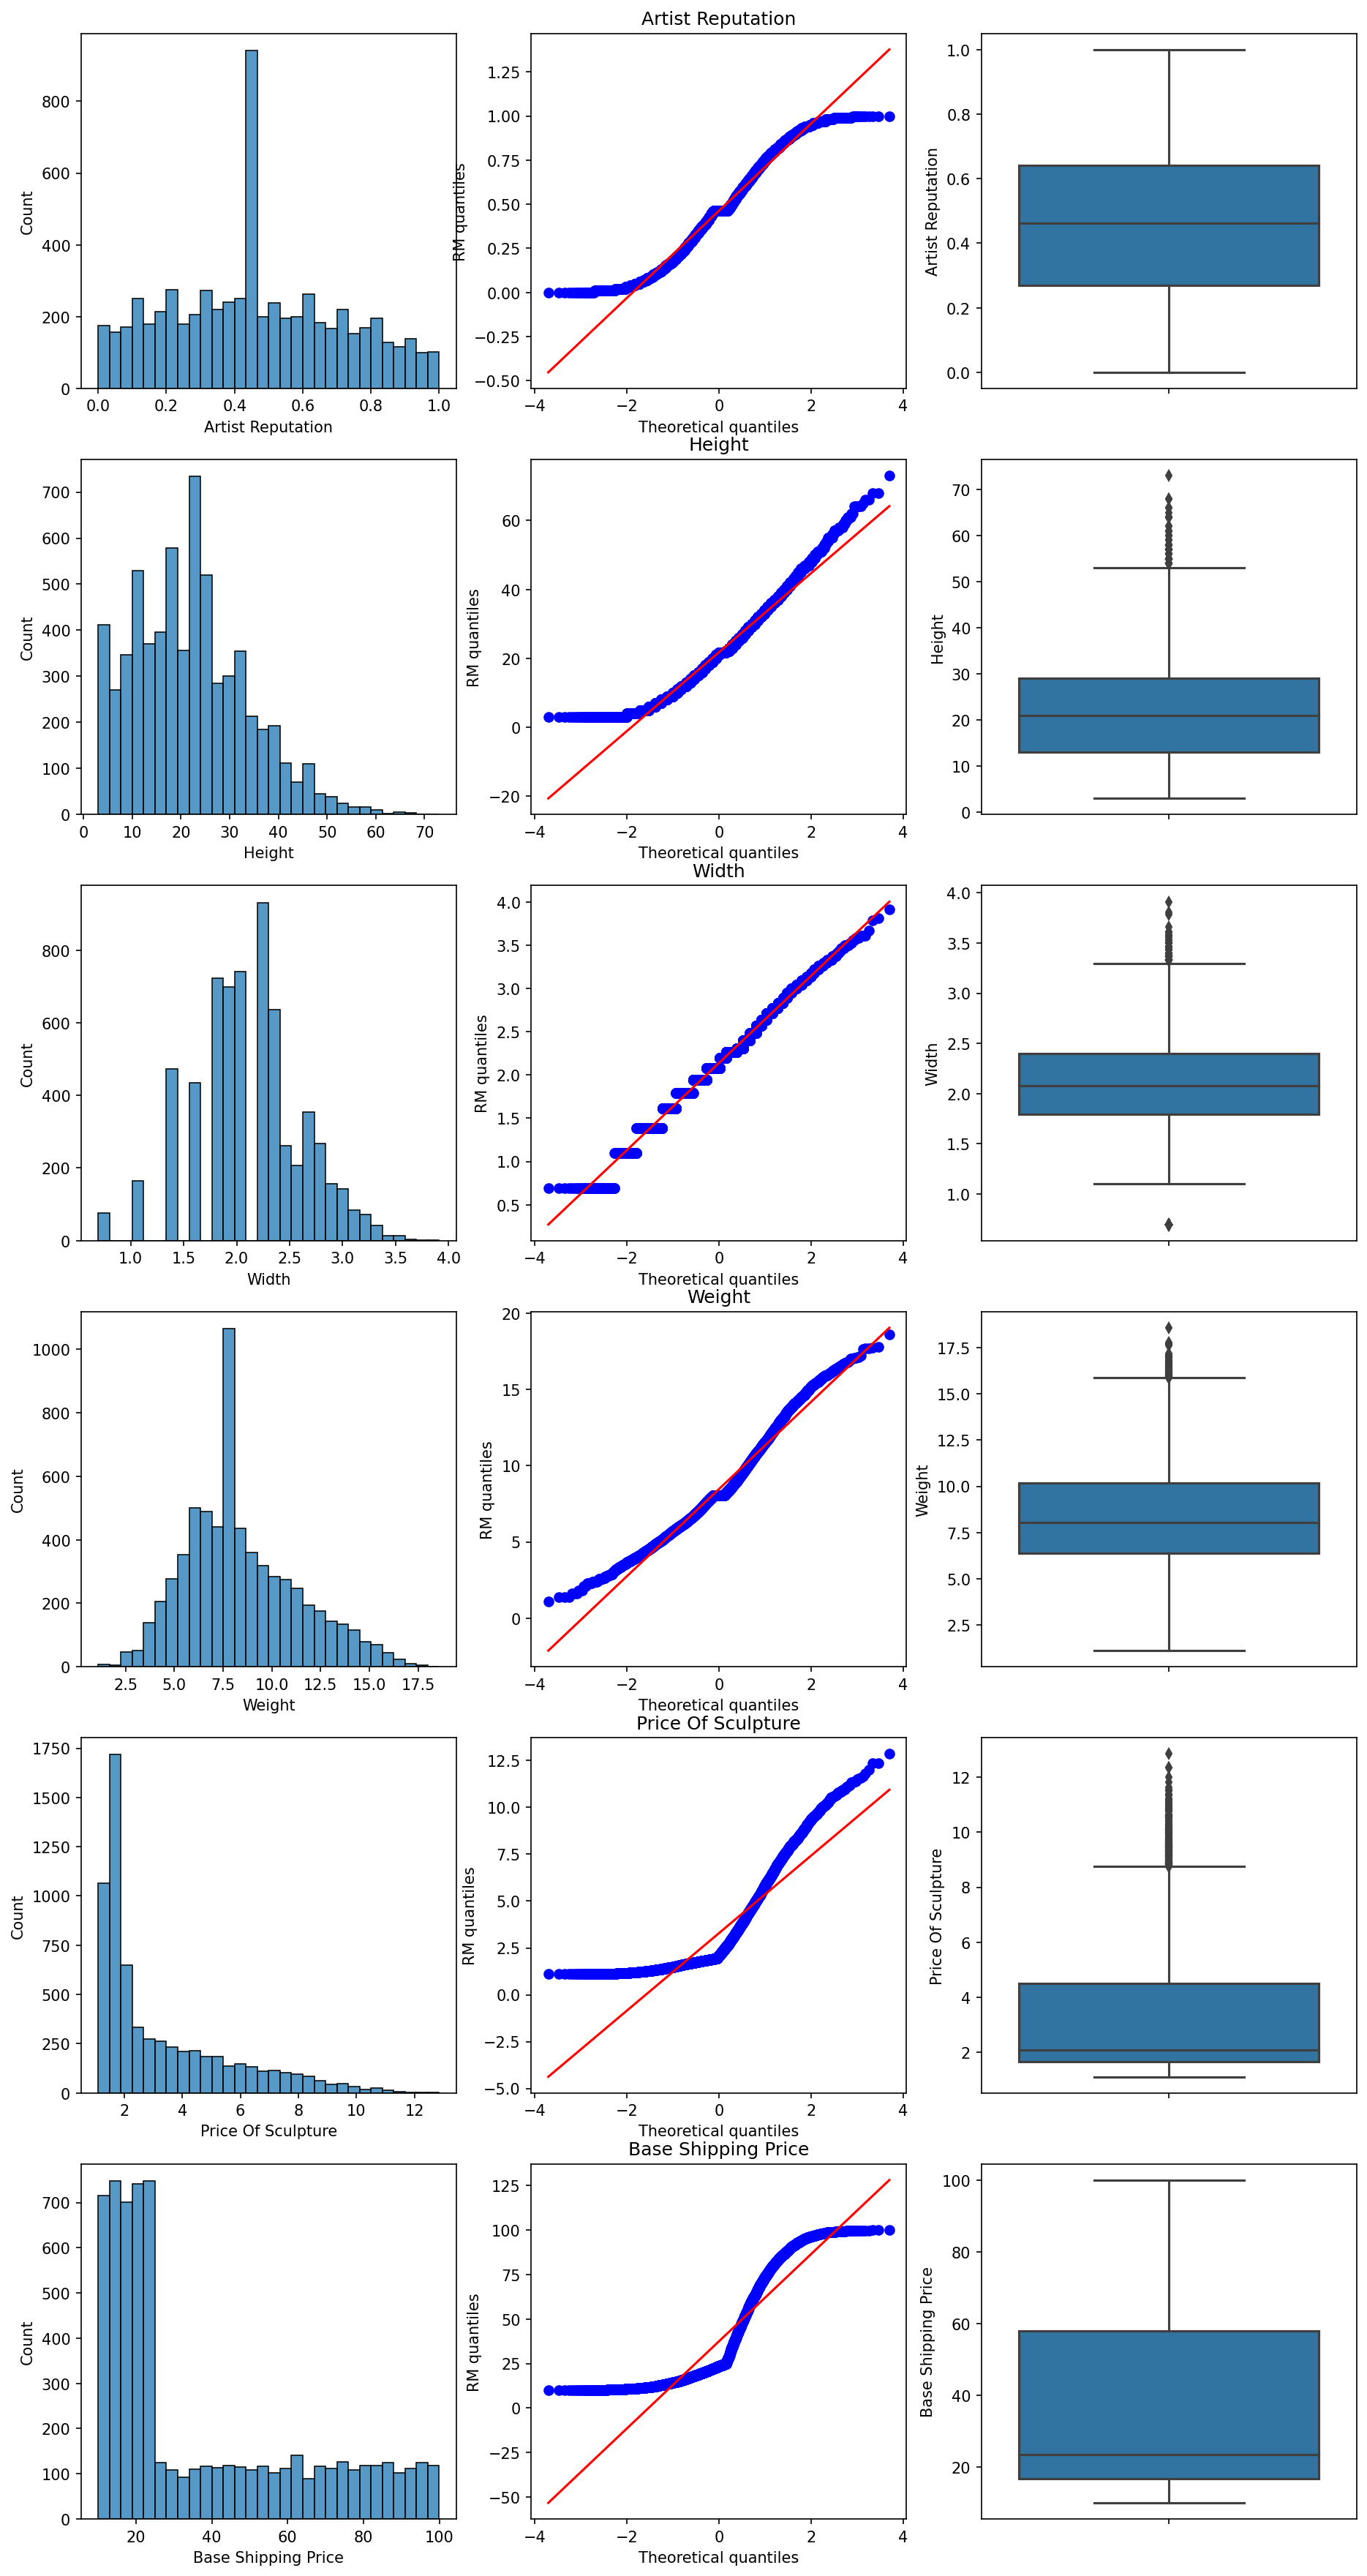

<IPython.core.display.Javascript object>

In [8]:
fig, ax = plt.subplots(
    nrows=len(num_features), ncols=3, figsize=(5 * 3, 5 * len(num_features)), dpi=150
)

for i, num_feature in enumerate(num_features):
    # histogram
    sns.histplot(train_df[num_feature], bins=30, ax=ax[i][0])

    # Q-Q plot
    stats.probplot(train_df[num_feature], dist="norm", plot=ax[i][1])
    ax[i][1].set_ylabel("RM quantiles")
    ax[i][1].set_title(num_feature)

    # boxplot
    sns.boxplot(y=train_df[num_feature], ax=ax[i][2])

plt.show()

## Feature Engineering

### Imputing Categorical Variables

In [9]:
train_df["delivery_offset"] = (
    train_df["Scheduled Date"] - train_df["Delivery Date"]
).dt.days
train_df["Customer State"] = train_df["Customer Location"].str.extract(r"([A-Z]{2})")

<IPython.core.display.Javascript object>

In [10]:
train_df.drop(
    [
        "Customer Id",
        "Delivery Date",
        "Scheduled Date",
        "Customer Location",
        "Artist Name",
    ],
    axis=1,
    inplace=True,
)

<IPython.core.display.Javascript object>

## Model Training

In [11]:
train_X_df = pd.get_dummies(train_df.drop(["Cost"], axis=1))
train_y_df = train_df[["Cost"]]

<IPython.core.display.Javascript object>

In [12]:
train_X, val_X, train_y, val_y = train_test_split(train_X_df, train_y_df, test_size=0.2)

<IPython.core.display.Javascript object>

### Linear Regression

Training a basic linear regression model as a benchmark

In [13]:
art_lr = LinearRegression()

<IPython.core.display.Javascript object>

In [14]:
scores = cross_validate(
    art_lr,
    train_X_df,
    train_y_df,
    scoring=("r2", "neg_mean_squared_error"),
    return_train_score=True,
    cv=3,
)

<IPython.core.display.Javascript object>

In [15]:
scores

{'fit_time': array([0.02228284, 0.02044582, 0.02051282]),
 'score_time': array([0.00678992, 0.00673509, 0.0066998 ]),
 'test_r2': array([-0.04584948,  0.06766735,  0.04790615]),
 'train_r2': array([0.08664404, 0.08081165, 0.12922047]),
 'test_neg_mean_squared_error': array([-1.43803783e+10, -3.19860813e+10, -1.19450491e+11]),
 'train_neg_mean_squared_error': array([-7.29616829e+10, -6.39917639e+10, -2.09270866e+10])}

<IPython.core.display.Javascript object>

### Gradient Boosting

In [16]:
art_gbr = GradientBoostingRegressor(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=8,
    random_state=42,
    loss="ls",
    min_samples_split=5,
)

<IPython.core.display.Javascript object>

In [17]:
scores = cross_validate(
    art_gbr,
    train_X_df,
    train_y_df,
    scoring=("r2", "neg_mean_squared_error"),
    return_train_score=True,
    cv=3,
)

/Users/jacob/Code/HackerEarth-Exhibit-Art/env/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/jacob/Code/HackerEarth-Exhibit-Art/env/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/jacob/Code/HackerEarth-Exhibit-Art/env/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


<IPython.core.display.Javascript object>

In [18]:
scores

{'fit_time': array([11.38504791, 12.7594831 , 15.15295005]),
 'score_time': array([0.03738809, 0.04202914, 0.04879808]),
 'test_r2': array([-2.91704689, -0.61836208,  0.17588999]),
 'train_r2': array([1.        , 1.        , 0.99999999]),
 'test_neg_mean_squared_error': array([-5.38591996e+10, -5.55220940e+10, -1.03393532e+11]),
 'train_neg_mean_squared_error': array([-169.71195948, -207.49126977, -203.09097214])}

<IPython.core.display.Javascript object>

### Gradient Boosting with Grid and Random Search

In [19]:
param_random = [
    {
        "n_estimators": [x for x in range(50, 500, 20)],
        "learning_rate": [0.1, 0.2, 0.3, 0.4, 0.5],
        "max_depth": [x for x in range(5, 20)],
        "min_samples_split": [x for x in range(2, 10)],
    }
]

<IPython.core.display.Javascript object>

In [20]:
art_gbr_random = RandomizedSearchCV(
    estimator=GradientBoostingRegressor(),
    param_distributions=param_random,
    cv=3,
    n_jobs=-1,
    verbose=2,
)

<IPython.core.display.Javascript object>

In [21]:
if TUNING:
    art_gbr_random.fit(train_X, train_y)

<IPython.core.display.Javascript object>

In [22]:
if TUNING:
    print(art_gbr_random.best_params_)
    art_gbr_random_best = art_gbr_random.best_estimator_
    pred_y = art_gbr_random_best.predict(val_X)
    print(mean_squared_error(val_y, pred_y))

<IPython.core.display.Javascript object>

Best params:

```python
{'n_estimators': 310, 'min_samples_split': 9, 'max_depth': 11, 'learning_rate': 0.1}

```

In [23]:
param_grid = [
    {
        "n_estimators": [450, 500, 550],
        "learning_rate": [0.15, 0.2],
        "max_depth": [13, 14],
        "min_samples_split": [11, 12],
    }
]

<IPython.core.display.Javascript object>

In [24]:
art_gbr_grid = GridSearchCV(
    estimator=GradientBoostingRegressor(),
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2,
)

<IPython.core.display.Javascript object>

In [25]:
if TUNING:
    art_gbr_grid.fit(train_X, train_y)

<IPython.core.display.Javascript object>

In [26]:
if TUNING:
    print(art_gbr_grid.best_params_)
    art_gbr_grid_best = art_gbr_grid.best_estimator_
    pred_y = art_gbr_grid_best.predict(val_X)
    print(mean_squared_error(val_y, pred_y))

<IPython.core.display.Javascript object>

Best params:

```python
{'learning_rate': 0.15, 'max_depth': 14, 'min_samples_split': 11, 'n_estimators': 500}

```

In [27]:
art_gbr_grid_best = GradientBoostingRegressor(
    **{
        "learning_rate": 0.15,
        "max_depth": 14,
        "min_samples_split": 11,
        "n_estimators": 500,
    }
)

<IPython.core.display.Javascript object>

In [28]:
scores = cross_validate(
    art_gbr_grid_best,
    train_X_df,
    train_y_df,
    scoring=("r2", "neg_mean_squared_error"),
    return_train_score=True,
    cv=3,
)

/Users/jacob/Code/HackerEarth-Exhibit-Art/env/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/jacob/Code/HackerEarth-Exhibit-Art/env/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/jacob/Code/HackerEarth-Exhibit-Art/env/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


<IPython.core.display.Javascript object>

In [29]:
scores

{'fit_time': array([23.02695298, 22.36989713, 21.40397096]),
 'score_time': array([0.08754396, 0.06867003, 0.06792283]),
 'test_r2': array([-2.55684762, -0.58009961,  0.24135132]),
 'train_r2': array([1., 1., 1.]),
 'test_neg_mean_squared_error': array([-4.89064776e+10, -5.42094011e+10, -9.51806985e+10]),
 'train_neg_mean_squared_error': array([-0.00085832, -0.00034366, -0.00080422])}

<IPython.core.display.Javascript object>

## Training on the entire dataset

In [30]:
art_gbr_grid_best = GradientBoostingRegressor(
    **{
        "learning_rate": 0.4,
        "max_depth": 7,
        "min_samples_split": 5,
        "n_estimators": 300,
    }
)

<IPython.core.display.Javascript object>

In [31]:
art_gbr_grid_best.fit(train_X_df, train_y_df)

/Users/jacob/Code/HackerEarth-Exhibit-Art/env/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


GradientBoostingRegressor(learning_rate=0.4, max_depth=7, min_samples_split=5,
                          n_estimators=300)

<IPython.core.display.Javascript object>

In [32]:
# filling Artist Reputation with the mean to make it normal distribution
test_df["Artist Reputation_NA"] = np.where(test_df["Artist Reputation"].isnull(), 1, 0)
test_df["Artist Reputation"].fillna(test_df["Artist Reputation"].mean(), inplace=True)

# filling Transport with the mode
test_df["Transport_NA"] = np.where(test_df["Transport"].isnull(), 1, 0)
test_df["Transport"].fillna(test_df["Transport"].mode().item(), inplace=True)

# filling Remote Location with the mode
test_df["Remote_Location_NA"] = np.where(test_df["Remote Location"].isnull(), 1, 0)
test_df["Remote Location"].fillna(
    test_df["Remote Location"].mode().item(), inplace=True
)

# filling Height with the mean
test_df["Height_NA"] = np.where(test_df["Height"].isnull(), 1, 0)
test_df["Height"].fillna(test_df["Height"].mean(), inplace=True)

# filling Width with the mean
test_df["Width_NA"] = np.where(test_df["Width"].isnull(), 1, 0)
test_df["Width"].fillna(test_df["Width"].mean(), inplace=True)

# filling Weight with the median, due to skew
test_df["Weight_NA"] = np.where(test_df["Weight"].isnull(), 1, 0)
test_df["Weight"].fillna(test_df["Weight"].median(), inplace=True)

# filling Material with NA values
test_df["Material_NA"] = np.where(test_df["Material"].isnull(), 1, 0)
test_df["Material"].fillna(test_df["Material"].mode().item(), inplace=True)

<IPython.core.display.Javascript object>

In [33]:
test_df["delivery_offset"] = (
    test_df["Scheduled Date"] - test_df["Delivery Date"]
).dt.days
test_df["Customer State"] = test_df["Customer Location"].str.extract(r"([A-Z]{2})")

<IPython.core.display.Javascript object>

In [34]:
test_df["Width"] = boxcox(test_df["Width"], 0)
test_df["Weight"] = boxcox(test_df["Weight"], 0)
test_df["Price Of Sculpture"] = boxcox(test_df["Price Of Sculpture"], 0)

<IPython.core.display.Javascript object>

In [35]:
test_df.drop(
    [
        "Delivery Date",
        "Scheduled Date",
        "Customer Location",
        "Artist Name",
    ],
    axis=1,
    inplace=True,
)

<IPython.core.display.Javascript object>

In [36]:
test_X_df = pd.get_dummies(test_df.set_index(["Customer Id"]))

<IPython.core.display.Javascript object>

In [37]:
test_pred_y = art_gbr_grid_best.predict(test_X_df)

<IPython.core.display.Javascript object>

In [38]:
final_df = test_X_df.reset_index()[["Customer Id"]]

<IPython.core.display.Javascript object>

In [39]:
final_df["Cost"] = test_pred_y

<IPython.core.display.Javascript object>

In [40]:
final_df.to_csv("data/solution.csv", index=False)

<IPython.core.display.Javascript object>